## Project: Dog Breed Classifier

In this project I build two models based on a tailored made Convolutional Neural Network and a pre-trained architectures based on the VGG16 and ResNet models.

Used Dataset from: http://vision.stanford.edu/aditya86/ImageNetDogs/main.html

<ul>
    <li>Table of Content
        <ul>
            <li>Download Images</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>
    
</ul>

First, we will import important models and the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
#!pip install tensorflow==2.15.0

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#! cp /content/drive/MyDrive/Dog_Breed_Dataset.zip .

In [ ]:
#!unzip Dog_Breed_Dataset.zip

In [ ]:
!python3 --version

Python 3.10.12


Check what GPU I've been assigned.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 14 14:38:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Memory info

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)


# set the path for the data base containing the images
file_path = "/content/Dog_Breed_Dataset"

#check existence of the path
if os.path.isdir(file_path):
    print("data set found!")
else:
    raise Exception("data set directory not found!")

data set found!


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16, VGG19, ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation

### Shuffle images from directory into train, valid, and test sets

In [ ]:
# Define paths
main_dir = os.path.join(file_path,'main')
train_dir = os.path.join(file_path,'train')
val_dir = os.path.join(file_path,'valid')
test_dir = os.path.join(file_path,'test')

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

In [ ]:
if os.path.isdir(file_path):
    if os.path.isdir(train_dir):
        print("train dir exist")
    else:
        print("creating train valid test sets")
        # Iterate through each class
        for class_dir in os.listdir(main_dir):
            class_path = os.path.join(main_dir, class_dir)
            if os.path.isdir(class_path):
                # Create train, val, test directories for the class
                os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
                os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)

                # Get all images in the class directory as a list of strings
                images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

                # Shuffle and split data
                train_imgs, test_imgs = train_test_split(images, test_size=(1-train_ratio), shuffle=True,
                                                 random_state=rs)
                val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio/(val_ratio+test_ratio)),
                                               shuffle=True,random_state=rs)

                # Copy files to corresponding directories
                for img in train_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))
                for img in val_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))
                for img in test_imgs:
                    shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))
else:
    raise Exception("data set directory not found!")

train dir exist


In [ ]:
# Print the count of items from each class

count = 0
for folder in os.listdir(train_dir):
    folder_pics = len(os.listdir(os.path.join(train_dir, folder)))
    print("The", folder, "class has", folder_pics, "pictures.")
    count += folder_pics

print(count,'total images')

The kelpie class has 107 pictures.
The Airedale class has 141 pictures.
The standard_poodle class has 111 pictures.
The Welsh_springer_spaniel class has 104 pictures.
The miniature_schnauzer class has 107 pictures.
The beagle class has 136 pictures.
The English_foxhound class has 109 pictures.
The African_hunting_dog class has 118 pictures.
The Newfoundland class has 136 pictures.
The German_shepherd class has 106 pictures.
The Lakeland_terrier class has 137 pictures.
The Cardigan class has 108 pictures.
The Walker_hound class has 107 pictures.
The Rottweiler class has 106 pictures.
The Sussex_spaniel class has 105 pictures.
The silky_terrier class has 128 pictures.
The black-and-tan_coonhound class has 111 pictures.
The collie class has 107 pictures.
The Kerry_blue_terrier class has 125 pictures.
The Eskimo_dog class has 104 pictures.
The Bouvier_des_Flandres class has 104 pictures.
The English_setter class has 112 pictures.
The Saluki class has 139 pictures.
The borzoi class has 105 

## Let us have a look at the classes we are going to classify

In [ ]:
# set up a dictionary with {class:image_path} taking a random image from each directory

image_examples_dict = {}
for folder in os.listdir(train_dir):
    pics = random.choice(os.listdir(os.path.join(train_dir, folder)))
    path_pic = os.path.join(train_dir, folder, pics)
    class_pic = folder
    image_examples_dict.update({class_pic: path_pic})

#print(image_examples_dict)

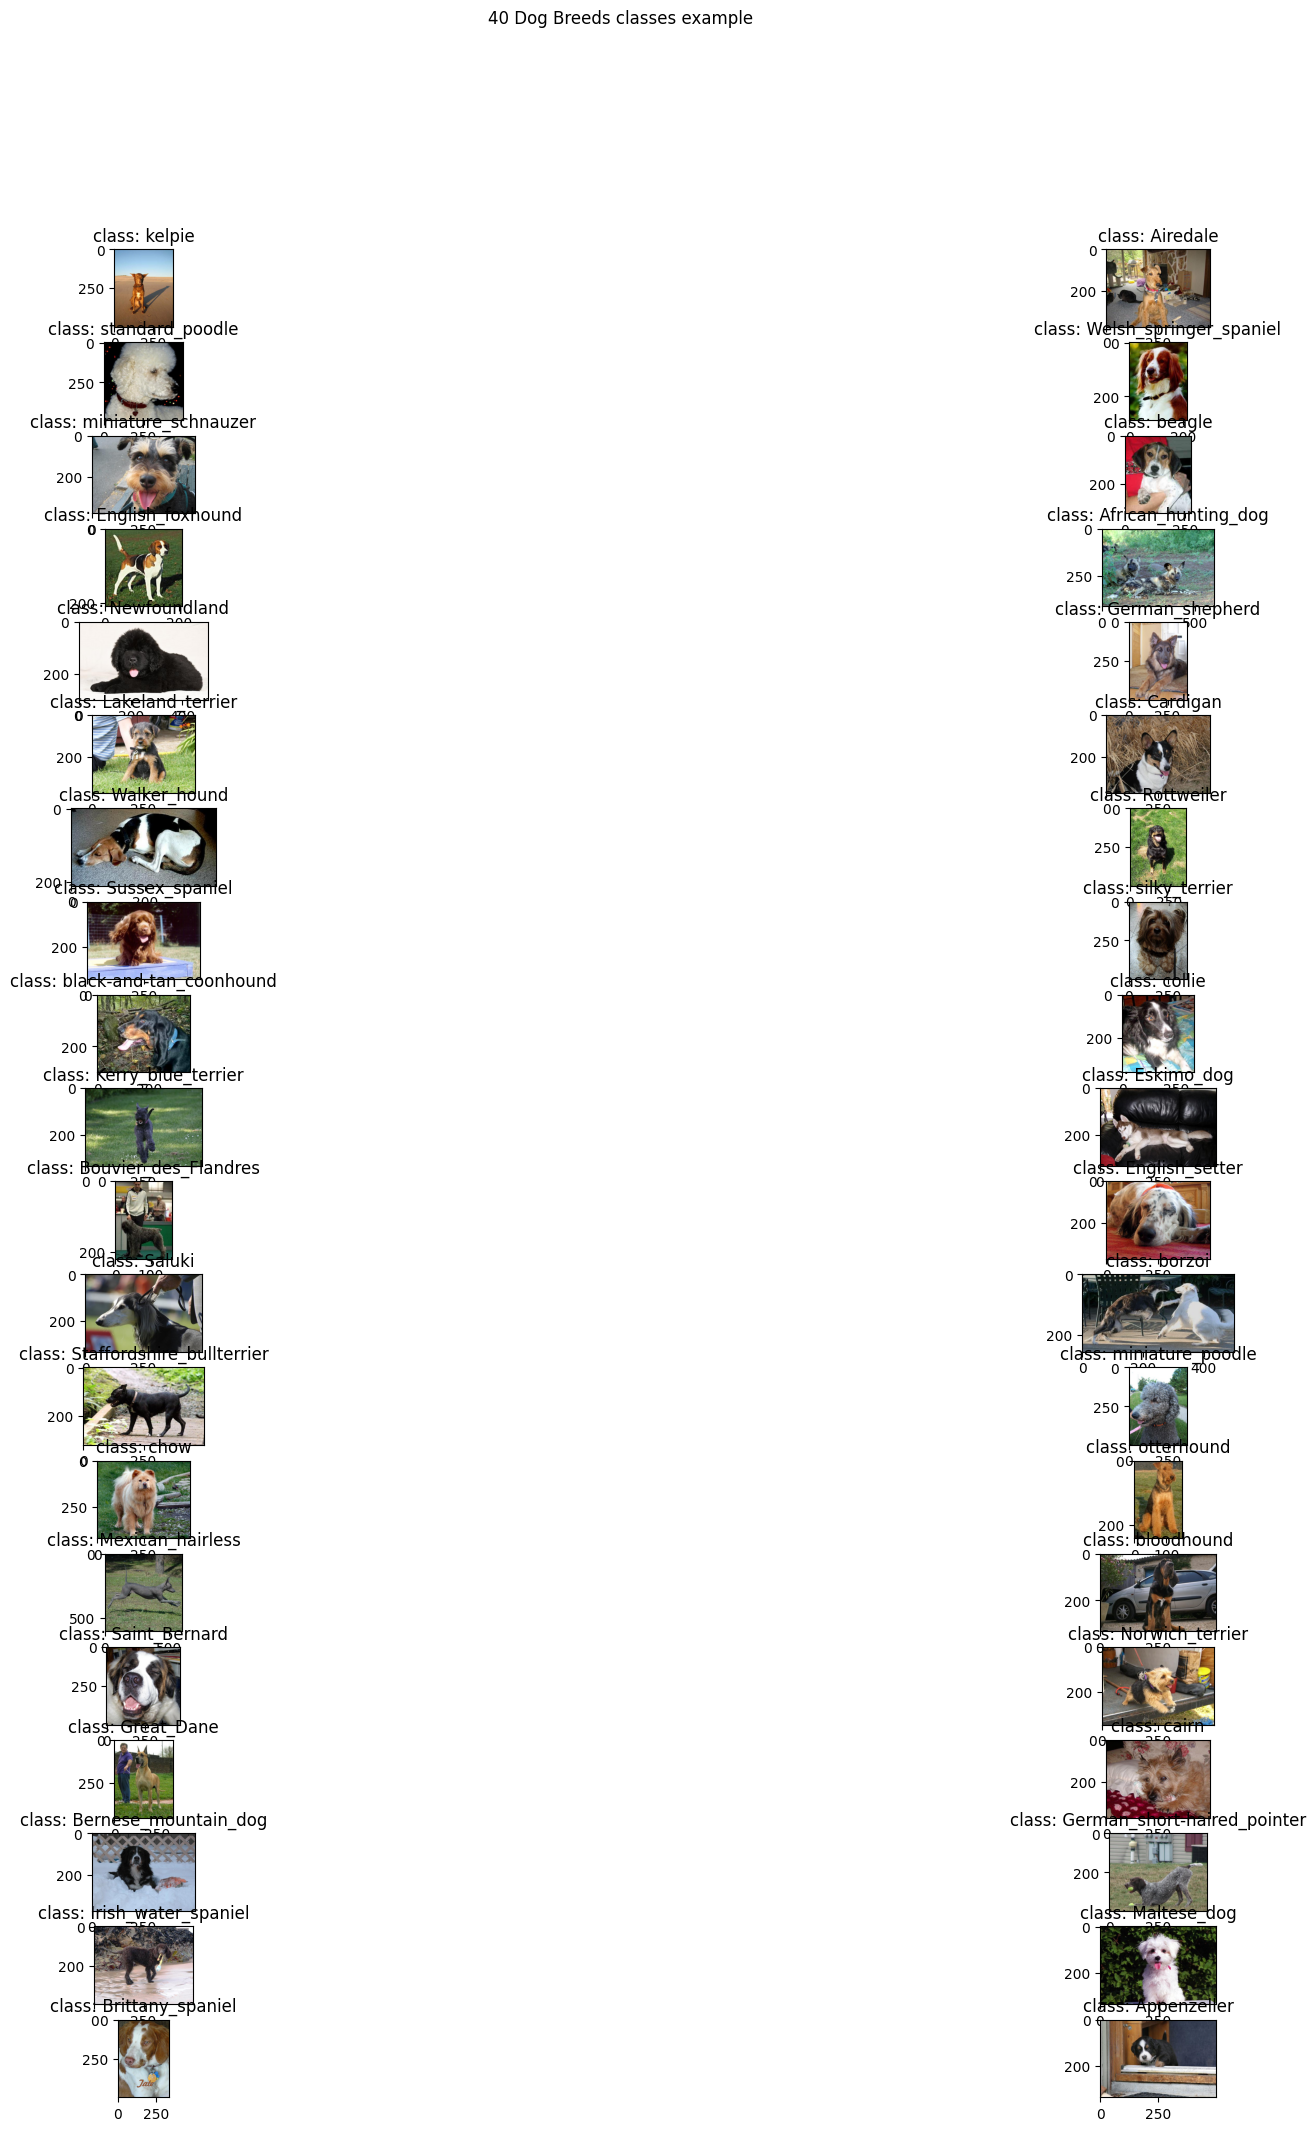

In [ ]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(24, 24)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        batch_image = list(image_examples_dict.items())
        image_data = plt.imread(batch_image[ind][1])
        ax2.imshow(image_data)
        ax2.set_title('class: {}'.format(batch_image[ind][0]))
        ind += 1

fig.suptitle('40 Dog Breeds classes example')
plt.show()

## Model definition


In [ ]:
# here I define some important parameter that are going to be used in both models

#num_classes =

image_resize = 224

batch_size_training = 56
batch_size_validation = 56

num_epochs = 8

Now we can generate train and validation set with ImageDataGenerator

In [ ]:
def get_data_generator(preprocessinput):
  # instantiate the image data generator
  data_generator = ImageDataGenerator(preprocessing_function=preprocessinput)

  train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical',
    seed=rs
    )

  validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed=rs
    )

  test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
  )
  return train_generator, validation_generator, test_generator

Here we define some optimization parameters that are going to be used with both models.

In [ ]:
train_generator_cnn, validation_generator_cnn, test_generator_cnn = get_data_generator(None)

num_classes = train_generator_cnn.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_cnn)
steps_per_epoch_validation = len(validation_generator_cnn)

print(steps_per_epoch_training,steps_per_epoch_validation)

Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


## Build the model

### we start with the tailored-made CNN model

In [ ]:
#del(model_cnn)

In [ ]:
def get_model_cnn():
    #
    input = Input(shape=(image_resize,image_resize,3,)) # (None, 224, 224, 3)

    x = Conv2D(64,(3,3),activation=None,padding="same", use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),activation=None,padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2,2))(x)

    x = Conv2D(128,(3,3),activation=None, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),activation=None, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(2,2))(x)

    x = Conv2D(256,(3,3),activation=None, use_bias=False, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(512,(3,3),activation=None, use_bias=False, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(1024,(3,3),activation=None, use_bias=False, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(1024,(3,3),activation='relu')(x)

    x = GlobalAveragePooling2D()(x)

    flat = Flatten()(x)

    x = Dropout(0.3)(flat)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)

    pred  = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=pred)

    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
model_cnn = get_model_cnn()

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1728      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36864     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                            

In [ ]:
model_cnn.layers

In [ ]:
%%time

start_datetime = datetime.now()

with tf.device('/gpu:0'):

  fit_cnn = model_cnn.fit(
    train_generator_cnn,
    steps_per_epoch=steps_per_epoch_training,
    epochs=16,
    validation_data=validation_generator_cnn,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
  )

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/16
257/257 [==============================] - 198s 652ms/step - loss: 4.7928 - accuracy: 0.0149 - val_loss: 4.7331 - val_accuracy: 0.0226
Epoch 2/16
257/257 [==============================] - 160s 622ms/step - loss: 4.6861 - accuracy: 0.0225 - val_loss: 4.6115 - val_accuracy: 0.0287
Epoch 3/16
257/257 [==============================] - 160s 622ms/step - loss: 4.5908 - accuracy: 0.0290 - val_loss: 4.5096 - val_accuracy: 0.0368
Epoch 4/16
257/257 [==============================] - 160s 622ms/step - loss: 4.5063 - accuracy: 0.0322 - val_loss: 4.4962 - val_accuracy: 0.0333
Epoch 5/16
257/257 [==============================] - 160s 621ms/step - loss: 4.4068 - accuracy: 0.0444 - val_loss: 4.3427 - val_accuracy: 0.0513
Epoch 6/16
257/257 [==============================] - 160s 622ms/step - loss: 4.3163 - accuracy: 0.0522 - val_loss: 4.6751 - val_accuracy: 0.0291
Epoch 7/16
257/257 [==============================] - 160s 622ms/step - loss: 4.2209 - accuracy: 0.0596 - val_loss: 4.2909 -

In [ ]:
# Evaluate CNN on test_generator

eval_cnn = model_cnn.evaluate(test_generator_cnn)
print('CNN Test loss: ', eval_cnn[0])
print('CNN Test Accuracy: ', eval_cnn[1])

3145/3145 [==============================] - 25s 8ms/step - loss: 4.6111 - accuracy: 0.0633
CNN Test loss:  4.611117839813232
CNN Test Accuracy:  0.0632750391960144


In [ ]:
def save_model(model, model_name):
    """"
    Save the model to a file in the saved_models directory:
    input takes two arguments:
    1: model: keras model object
    2: model_name: string
    """
    model_dir = "."
    file_name = os.path.join(model_dir, model_name)

    # check existance of the directory
    if os.path.isdir(model_dir):
        # check existance of the file
        if os.path.isfile(file_name):
            os.remove(file_name)
            model.save(file_name)
            print("model updated")
        else:
            model.save(file_name)
            print("model created")
    else:
        raise Exception("model_dir directory not found")


In [ ]:
save_model(model_cnn, "classifier_cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model updated


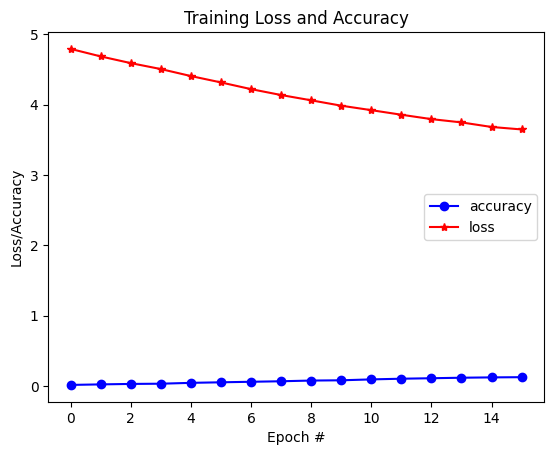

In [ ]:
# Model accuracy and loss vs epoch
plt.plot(fit_cnn.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_cnn.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

# ResNet50

### Instantiate the generator for resnet50

In [ ]:
train_generator_r, validation_generator_r, test_generator_r = get_data_generator(preprocess_input_resnet)

num_classes = train_generator_r.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_r)
steps_per_epoch_validation = len(validation_generator_r)

print(steps_per_epoch_training,steps_per_epoch_validation)

Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


In [ ]:
def get_model_resnet():

    base_model = ResNet50(input_shape=[image_resize, image_resize, 3],
                          weights='imagenet', include_top=False) #imports the ResNet50 model and discards the last layer.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.3)(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512,activation='relu')(x)

    preds = Dense(num_classes,activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from ResNet backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model_resnet = get_model_resnet()

model_resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [ ]:
model_resnet.layers

In [ ]:
%%time

start_datetime = datetime.now()

fit_resnet = model_resnet.fit(
    train_generator_r,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_r,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
257/257 [==============================] - 70s 242ms/step - loss: 1.9685 - accuracy: 0.4883 - val_loss: 1.0503 - val_accuracy: 0.6894
Epoch 2/8
257/257 [==============================] - 58s 226ms/step - loss: 1.0446 - accuracy: 0.6881 - val_loss: 0.9581 - val_accuracy: 0.7081
Epoch 3/8
257/257 [==============================] - 57s 219ms/step - loss: 0.8774 - accuracy: 0.7265 - val_loss: 0.9730 - val_accuracy: 0.7107
Epoch 4/8
257/257 [==============================] - 59s 228ms/step - loss: 0.8047 - accuracy: 0.7473 - val_loss: 0.9238 - val_accuracy: 0.7255
Epoch 5/8
257/257 [==============================] - 56s 219ms/step - loss: 0.6758 - accuracy: 0.7850 - val_loss: 0.9063 - val_accuracy: 0.7297
Epoch 6/8
257/257 [==============================] - 57s 220ms/step - loss: 0.6415 - accuracy: 0.7945 - val_loss: 0.9503 - val_accuracy: 0.7397
Epoch 7/8
257/257 [==============================] - 58s 224ms/step - loss: 0.5587 - accuracy: 0.8187 - val_loss: 0.9544 - val_accuracy:

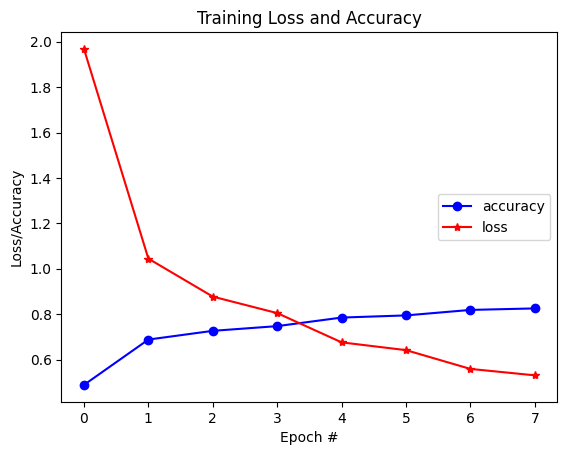

In [ ]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_resnet.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_resnet.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [ ]:
eval_resnet = model_resnet.evaluate(test_generator_r)
print('ResNet Test loss: ', eval_resnet[0])
print('ResNet Test Accuracy: ', eval_resnet[1])

3145/3145 [==============================] - 31s 10ms/step - loss: 0.9158 - accuracy: 0.7424
ResNet Test loss:  0.915779173374176
ResNet Test Accuracy:  0.7424483299255371


In [ ]:
# Save the model to a file
save_model(model_resnet, "classifier_resnet_model.h5")

model created


# VGG16

### Instantiate the data generator with the VGG16 preprocessing

In [ ]:
train_generator_v, validation_generator_v, test_generator_v = get_data_generator(preprocess_input_resnet)

num_classes = train_generator_v.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_v)
steps_per_epoch_validation = len(validation_generator_v)

print(steps_per_epoch_training,steps_per_epoch_validation)


Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


In [ ]:
def get_model_vgg16():

    base_model = VGG16(input_shape=[image_resize, image_resize, 3],
                       weights='imagenet', include_top=False) #imports the VGG16 model and discards the last layer.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.3)(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512,activation='relu')(x)

    preds = Dense(num_classes,activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from VGG16 backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model_vgg = get_model_vgg16()

model_vgg.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
model_vgg.layers

In [ ]:
%%time

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator_v,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_v,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
257/257 [==============================] - 92s 315ms/step - loss: 3.3281 - accuracy: 0.2676 - val_loss: 1.6071 - val_accuracy: 0.5586
Epoch 2/8
257/257 [==============================] - 75s 293ms/step - loss: 1.8991 - accuracy: 0.4716 - val_loss: 1.3550 - val_accuracy: 0.6148
Epoch 3/8
257/257 [==============================] - 75s 292ms/step - loss: 1.6536 - accuracy: 0.5315 - val_loss: 1.2938 - val_accuracy: 0.6203
Epoch 4/8
257/257 [==============================] - 76s 294ms/step - loss: 1.5006 - accuracy: 0.5688 - val_loss: 1.2401 - val_accuracy: 0.6384
Epoch 5/8
257/257 [==============================] - 76s 294ms/step - loss: 1.3916 - accuracy: 0.5911 - val_loss: 1.2172 - val_accuracy: 0.6435
Epoch 6/8
257/257 [==============================] - 76s 294ms/step - loss: 1.3186 - accuracy: 0.6101 - val_loss: 1.1983 - val_accuracy: 0.6503
Epoch 7/8
257/257 [==============================] - 76s 294ms/step - loss: 1.2846 - accuracy: 0.6209 - val_loss: 1.1989 - val_accuracy:

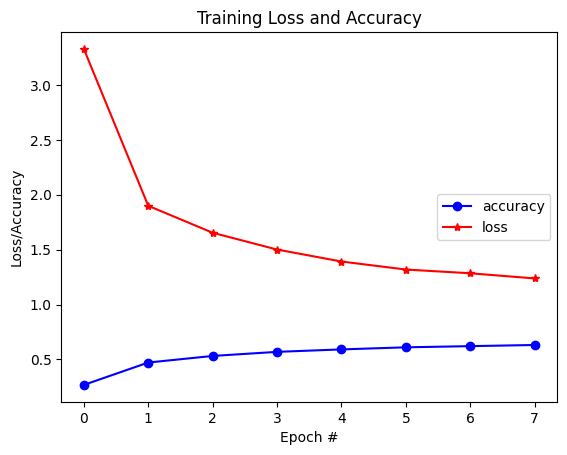

In [ ]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [ ]:
eval_vgg = model_vgg.evaluate(test_generator_v)
print('VGG Test loss: ', eval_vgg[0])
print('VGG Test Accuracy: ', eval_vgg[1])

3145/3145 [==============================] - 32s 10ms/step - loss: 1.1092 - accuracy: 0.6715
VGG Test loss:  1.1092089414596558
VGG Test Accuracy:  0.6715421080589294


In [ ]:
# Save the model to a file
save_model(model_vgg, "classifier_vgg16_model.h5")

model created


# VGG19

In [ ]:
# restart the notbook here before moving on

In [ ]:
train_generator_v, validation_generator_v, test_generator_v = get_data_generator(preprocess_input_vgg19)

num_classes = train_generator_v.num_classes
print("number of automatically found classes: ",num_classes)

steps_per_epoch_training = len(train_generator_v)
steps_per_epoch_validation = len(validation_generator_v)

print(steps_per_epoch_training,steps_per_epoch_validation)

Found 14338 images belonging to 120 classes.
Found 3097 images belonging to 120 classes.
Found 3145 images belonging to 120 classes.
number of automatically found classes:  120
257 56


In [ ]:
def get_model_vgg19():

    base_model = VGG19(input_shape=[image_resize, image_resize, 3],
                       weights='imagenet', include_top=False) #imports the VGG19 model and discards the last layer.
    x = base_model.output # (None, None, None, 512)
    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.3)(x)
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512,activation='relu')(x)

    preds = Dense(num_classes,activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=preds)

    #Freeze layers from VGG backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model_vgg = get_model_vgg19()

model_vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
model_vgg.layers

In [ ]:
%%time

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator_v,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator_v,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
257/257 [==============================] - 91s 349ms/step - loss: 3.1680 - accuracy: 0.2917 - val_loss: 1.5709 - val_accuracy: 0.5602
Epoch 2/8
257/257 [==============================] - 89s 347ms/step - loss: 1.8170 - accuracy: 0.4950 - val_loss: 1.3259 - val_accuracy: 0.6161
Epoch 3/8
257/257 [==============================] - 89s 348ms/step - loss: 1.5829 - accuracy: 0.5462 - val_loss: 1.2464 - val_accuracy: 0.6409
Epoch 4/8
257/257 [==============================] - 90s 348ms/step - loss: 1.4515 - accuracy: 0.5813 - val_loss: 1.2160 - val_accuracy: 0.6542
Epoch 5/8
257/257 [==============================] - 89s 348ms/step - loss: 1.3181 - accuracy: 0.6169 - val_loss: 1.2401 - val_accuracy: 0.6435
Epoch 6/8
257/257 [==============================] - 89s 347ms/step - loss: 1.2874 - accuracy: 0.6209 - val_loss: 1.1591 - val_accuracy: 0.6577
Epoch 7/8
257/257 [==============================] - 89s 346ms/step - loss: 1.2181 - accuracy: 0.6377 - val_loss: 1.1511 - val_accuracy:

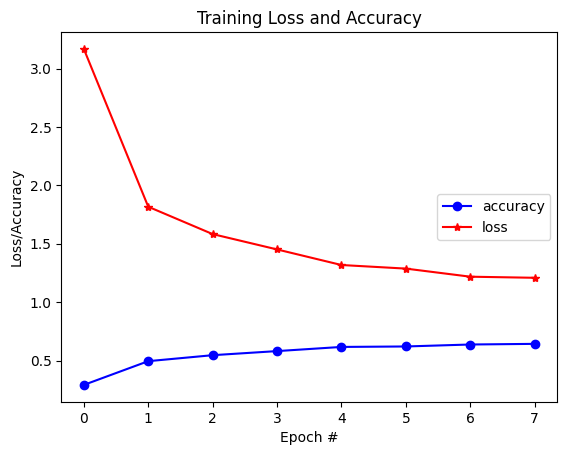

In [ ]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [ ]:
eval_vgg = model_vgg.evaluate(test_generator_v)
print('VGG Test loss: ', eval_vgg[0])
print('VGG Test Accuracy: ', eval_vgg[1])

3145/3145 [==============================] - 37s 12ms/step - loss: 1.1509 - accuracy: 0.6734
VGG Test loss:  1.1509140729904175
VGG Test Accuracy:  0.6734499335289001


In [ ]:
# Save the model to a file
save_model(model_vgg, "classifier_vgg19_model.h5")

model created


#  Persist the models and evaluate on the test set

In [ ]:
# load the models

#model_cnn = load_model('../saved_models/classifier_cnn_model.h5')

#model_vgg = load_model('../saved_models/classifier_vgg_model.h5')

To summarize, the accuracy metric on the test set was


  ResNet: 0.7424

  VGG16: 0.6715
  
  VGG19: 0.6734